# Parameterized Filter

- Why parameterize filters?
    - Creating learnable filters.
- How to implement?
    - PyTorch, An automatic differentiation tool and gpu-speed up.
- What are frequently questions?
    1. The frequency response of weight of each filter is non-smooth.
        - **Answer**: Window function does not work.

## Prepare requirements

- Package: numpy, math, torch, torchaudio, and matplotlib.
- Waveform: is loaded from '../piece_20_32k.wav' using `torchaudio.load`

In [1]:
import numpy as np
import math
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

In [2]:
wav_file = '../piece_20_32k.wav'
waveform, samplerate = torchaudio.load(wav_file, normalization=True)
print(waveform.shape, samplerate)

torch.Size([1, 785077]) 32000


## Define the parameterized filter

- The parameterized filter is created in form of encapsulation and it can be reused any where.

In [3]:
class PFilter(nn.Module):
    """Parameterized Filter.
    Here is only one filter: 
    1. bandpass filter, it's parameters are low and high cutoff frequencies.
    """
    
    def _hz2mel(self, hz):
        return 2595 * np.log10(1 + hz / 700.)
    
    def _mel2hz(self, mel):
        return 700 * (10 ** (mel / 2595.) - 1)
    
    def _init_filter(self):
        """Iniinitialize parameters of each filter. Only calculate half of filter
        and copy another half. The mid of filter is set to avoid non-smooth.
        Low cutoff frequency: `low_hz`
        High cutoff frequency: `band_hz`
        """
        mel = np.linspace(self._hz2mel(self.min_hz), self._hz2mel(self.max_hz), num=self.out_channels+1)
        hz = self._mel2hz(mel)
        self.low_hz = nn.Parameter(torch.Tensor(hz[:-1], device=self.device).view(-1, 1))
        self.band_hz = nn.Parameter(torch.Tensor(np.diff(hz), device=self.device).view(-1, 1))
        self.n_ = 2 * math.pi * torch.arange(-(self.kernel_size//2), 0, 
                                             device=self.device).view(1, -1) / self.sample_rate
        # Hamming window: The 'n' of window is different from the 'n' of filters (n_)
        # Note that the frequency response of filters will be non-smooth if window not works.
        n = torch.linspace(0, (self.kernel_size/2)-1, self.kernel_size//2, device=self.device)
        self.window = 0.54 - 0.46 * torch.cos(2 * math.pi * n / self.kernel_size)
        
    def _compute_weight(self, frequency=False):
        """Computer weight of all filters. The phase will be implemented
        before `F.conv1d`.
        """
        low = self.min_hz + torch.abs(self.low_hz)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz), self.min_hz, self.max_hz)
        f_t_low = torch.matmul(low, self.n_)
        f_t_high = torch.matmul(high, self.n_)
        filters_l = (torch.sin(f_t_high) - torch.sin(f_t_low)) / (self.n_/2.) * self.window
        filters_c = 2.*(high - low) # if x to 0, sin(x)/x = 1, then g(n,f1,f2)=2f2-2f1
        filters_r = torch.flip(filters_l, dims=(1,))
        filters = torch.cat([filters_l, filters_c, filters_r], dim=1)
        filters = filters / filters_c#torch.norm(filters, dim=1, keepdim=True)
        filters = filters.view(self.out_channels, 1, self.kernel_size)
        if not frequency:
            return filters
        else:
            return low, high, filters
    
    def __getitem__(self, i):
        """Ouput the filter's weight at i.
        """
        low, high, filters = self._compute_weight(frequency=True)
        t2n = lambda x: x.detach().cpu().numpy()
        return t2n(low[i,0]), t2n(high[i,0]), t2n(filters[i,0,:])
        
        
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False, device="cpu", mode='bandpass', sample_rate=16000, min_hz=50, max_hz=None, min_band_hz=50, win_fn="Hamming"):
        """Create a set of parameterized filters.
        """
        super(PFilter,self).__init__()
        assert in_channels == 1, "The number of channel != 1 ()".format(in_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        assert mode =='bandpass', "Unknown Filter! The filter is {}.".format(mode)
        self.sample_rate = sample_rate
        self.min_hz = min_hz
        self.max_hz = max_hz if max_hz else sample_rate // 2 - (min_hz + min_band_hz)
        self.min_band_hz = min_band_hz
        self.device = device
        assert win_fn == "Hamming", "The window is {} != Hamming".format(win_fn)
        self.win_fn = win_fn
        self._init_filter()
        
    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_filter)
            Batch of sinc filters activations.
        """
        weight = self._compute_weight()
        return F.conv1d(waveforms, weight, bias=self.bias, stride=self.stride, padding=self.padding, 
                        dilation=self.dilation, groups=self.groups)

## Create a set of parameterized filters and run  it

1. Create a set of parameterized filters using `PFliter`.
2. Define readable images.
3. List filters.

In [4]:
f = PFilter(1, 5, 251, sample_rate=32000)

In [5]:
def fig(signal, kernel_size=251, sample_rate=32000):
    plt.figure(figsize=(15, 3))
    plt.subplot(1,2,1)
    plt.plot(signal)
    plt.subplot(1,2,2)
    plt.plot(np.linspace(0, sample_rate//2, kernel_size//2+1), np.abs(np.fft.fft(signal))[:kernel_size//2+1])
    plt.show()

Low and high cutoff frequencies are 100 Hz and 793 Hz, respectively.


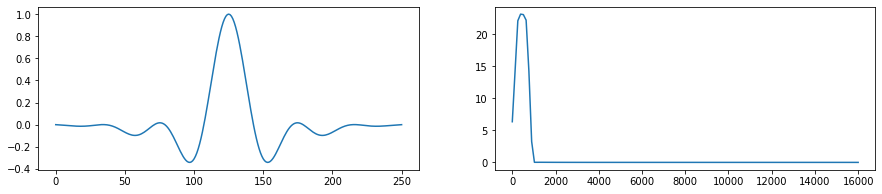

Low and high cutoff frequencies are 743 Hz and 1988 Hz, respectively.


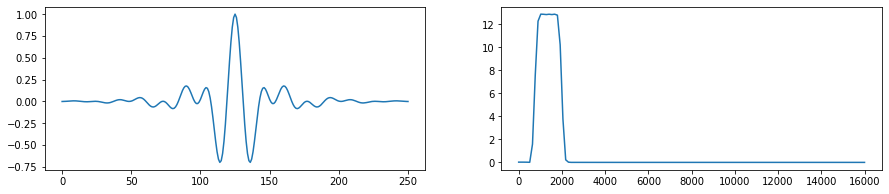

Low and high cutoff frequencies are 1938 Hz and 4209 Hz, respectively.


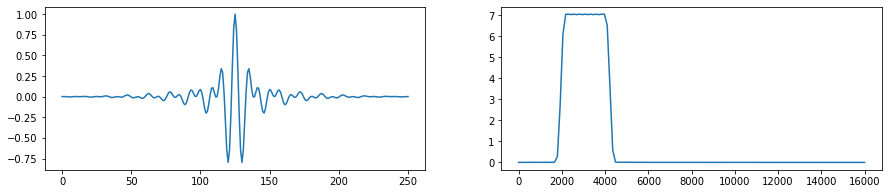

Low and high cutoff frequencies are 4159 Hz and 8335 Hz, respectively.


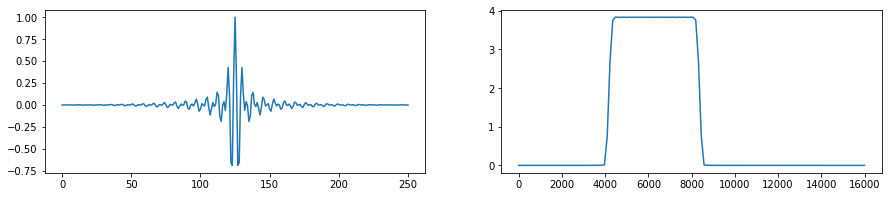

Low and high cutoff frequencies are 8285 Hz and 15900 Hz, respectively.


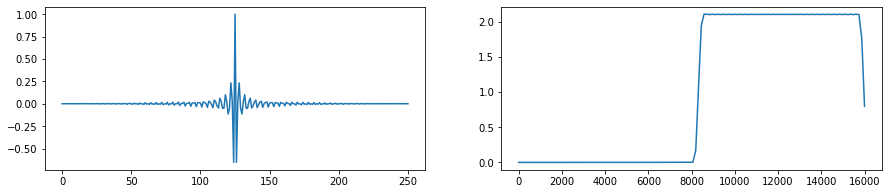

In [6]:
for i in range(f.out_channels):
    l, h, s = f[i]
    print("Low and high cutoff frequencies are %d Hz and %d Hz, respectively." % (l, h))
    fig(s)
    time.sleep(1)

## Thanks for you attention

- More detail in my github: `https://github.com/mechanicalsea/spectra/tree/master/notebooks`